In [16]:
%matplotlib inline
# Load required packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib as mpl
import scipy.interpolate as interpolate
mpl.rcParams['figure.figsize'] = (10.0, 8.0)

In [46]:
mpl.__version__

'1.5.3'

In [13]:
# Define plotting functions hsvtorgb and piper
def hsvtorgb(H, S, V):
    '''
    Converts hsv colorspace to rgb
    INPUT:
        H: [mxn] matrix of hue ( between 0 and 2pi )
        S: [mxn] matrix of saturation ( between 0 and 1 )
        V: [mxn] matrix of value ( between 0 and 1 )
    OUTPUT:
        R: [mxn] matrix of red ( between 0 and 1 )
        G: [mxn] matrix of green ( between 0 and 1 )
        B: [mxn] matrix of blue ( between 0 and 1 )
    '''
    # conversion (from http://en.wikipedia.org/wiki/HSL_and_HSV)
    C = V * S
    Hs = H / (np.pi / 3)
    X = C * (1 - np.abs(np.mod(Hs, 2.0 * np.ones_like(Hs)) - 1))
    N = np.zeros_like(H)
    # create empty RGB matrices
    R = np.zeros_like(H)
    B = np.zeros_like(H)
    G = np.zeros_like(H)
    # assign values
    h = np.floor(Hs)
    # h=0
    R[h == 0] = C[h == 0]
    G[h == 0] = X[h == 0]
    B[h == 0] = N[h == 0]
    # h=1
    R[h == 1] = X[h == 1]
    G[h == 1] = C[h == 1]
    B[h == 1] = N[h == 1]
    # h=2
    R[h == 2] = N[h == 2]
    G[h == 2] = C[h == 2]
    B[h == 2] = X[h == 2]
    # h=3
    R[h == 3] = N[h == 3]
    G[h == 3] = X[h == 3]
    B[h == 3] = C[h == 3]
    # h=4
    R[h == 4] = X[h == 4]
    G[h == 4] = N[h == 4]
    B[h == 4] = C[h == 4]
    # h=5
    R[h == 5] = C[h == 5]
    G[h == 5] = N[h == 5]
    B[h == 5] = X[h == 5]
    # match values
    m = V - C
    R = R + m
    G = G + m
    B = B + m
    return (R, G, B)


def piper(dat_piper, plottitle, alphalevel, color):
    '''
    Create a Piper plot
    INPUT:
        dat_piper: [nx8] matrix, chemical analysis in mg/L
                    order: Ca Mg Na K HCO3 CO3 Cl SO4
        plottitle: string with title of Piper plot
        alphalevel: transparency level of points. If 1, points are opaque
        color: boolean, use background coloring of Piper plot
    OUTPUT:
        figure with piperplot
        dictionary with:
            if color = False:
                cat: [nx3] meq% of cations, order: Ca Mg Na+K
                an:  [nx3] meq% of anions,  order: HCO3+CO3 SO4 Cl
            if color = True:
                cat: [nx3] RGB triple cations
                an:  [nx3] RGB triple anions
                diamond: [nx3] RGB triple central diamond
    '''
    # Basic shape of piper plot
    offset = 0.05
    offsety = offset * np.tan(np.pi / 3)
    h = 0.5 * np.tan(np.pi / 3)
    ltriangle_x = np.array([0, 0.5, 1, 0])
    ltriangle_y = np.array([0, h, 0, 0])
    rtriangle_x = ltriangle_x + 2 * offset + 1
    rtriangle_y = ltriangle_y
    diamond_x = np.array([0.5, 1, 1.5, 1, 0.5]) + offset
    diamond_y = h * (np.array([1, 2, 1, 0, 1])) + (offset * np.tan(np.pi / 3))
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal', frameon=False, xticks=[], yticks=[])
    ax.plot(ltriangle_x, ltriangle_y, '-k')
    ax.plot(rtriangle_x, rtriangle_y, '-k')
    ax.plot(diamond_x, diamond_y, '-k')
    # labels and title
    plt.title(plottitle)
    plt.text(-offset, -offset, u'$Ca^{2+}$', horizontalalignment='left', verticalalignment='center')
    plt.text(0.5, h + offset, u'$Mg^{2+}$', horizontalalignment='center', verticalalignment='center')
    plt.text(1 + offset, -offset, u'$Na^+ + K^+$', horizontalalignment='right', verticalalignment='center')
    plt.text(1 + offset, -offset, u'$HCO_3^- + CO_3^{2-}$', horizontalalignment='left', verticalalignment='center')
    plt.text(1.5 + 2 * offset, h + offset, u'$SO_4^{2-}$', horizontalalignment='center', verticalalignment='center')
    plt.text(2 + 3 * offset, -offset, u'$Cl^-$', horizontalalignment='right', verticalalignment='center')

    # Convert chemistry into plot coordinates
    gmol = np.array([40.078, 24.305, 22.989768, 39.0983, 61.01714, 60.0092, 35.4527, 96.0636])
    eqmol = np.array([2., 2., 1., 1., 1., 2., 1., 2.])
    n = dat_piper.shape[0]
    meqL = (dat_piper / gmol) * eqmol
    sumcat = np.sum(meqL[:, 0:4], axis=1)
    suman = np.sum(meqL[:, 4:8], axis=1)
    cat = np.zeros((n, 3))
    an = np.zeros((n, 3))
    cat[:, 0] = meqL[:, 0] / sumcat  # Ca
    cat[:, 1] = meqL[:, 1] / sumcat  # Mg
    cat[:, 2] = (meqL[:, 2] + meqL[:, 3]) / sumcat  # Na+K
    an[:, 0] = (meqL[:, 4] + meqL[:, 5]) / suman  # HCO3 + CO3
    an[:, 2] = meqL[:, 6] / suman  # Cl
    an[:, 1] = meqL[:, 7] / suman  # SO4

    # Convert into cartesian coordinates
    cat_x = 0.5 * (2 * cat[:, 2] + cat[:, 1])
    cat_y = h * cat[:, 1]
    an_x = 1 + 2 * offset + 0.5 * (2 * an[:, 2] + an[:, 1])
    an_y = h * an[:, 1]
    d_x = an_y / (4 * h) + 0.5 * an_x - cat_y / (4 * h) + 0.5 * cat_x
    d_y = 0.5 * an_y + h * an_x + 0.5 * cat_y - h * cat_x

    # plot data
    plt.plot(cat_x, cat_y, '.k', alpha=alphalevel)
    plt.plot(an_x, an_y, '.k', alpha=alphalevel)
    plt.plot(d_x, d_y, '.k', alpha=alphalevel)

    # color coding Piper plot
    if color == False:
        # add density color bar if alphalevel < 1
        if alphalevel < 1.0:
            ax1 = fig.add_axes([0.75, 0.4, 0.01, 0.2])
            cmap = plt.cm.gray_r
            norm = mpl.colors.Normalize(vmin=0, vmax=1 / alphalevel)
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                            norm=norm,
                                            orientation='vertical')
            cb1.set_label('Dot Density')

        return (dict(cat=cat,an=an))
    else:

        # create empty grids to interpolate to
        x0 = 0.5
        y0 = x0 * np.tan(np.pi / 6)
        X = np.reshape(np.repeat(np.linspace(0, 2 + 2 * offset, 1000), 1000), (1000, 1000), 'F')
        Y = np.reshape(np.repeat(np.linspace(0, 2 * h + offsety, 1000), 1000), (1000, 1000), 'C')
        H = np.nan * np.zeros_like(X)
        S = np.nan * np.zeros_like(X)
        V = np.nan * np.ones_like(X)
        A = np.nan * np.ones_like(X)
        # create masks for cation, anion triangle and upper and lower diamond
        ind_cat = np.logical_or(np.logical_and(X < 0.5, Y < 2 * h * X),
                                np.logical_and(X > 0.5, Y < (2 * h * (1 - X))))
        ind_an = np.logical_or(np.logical_and(X < 1.5 + (2 * offset), Y < 2 * h * (X - 1 - 2 * offset)),
                               np.logical_and(X > 1.5 + (2 * offset), Y < (2 * h * (1 - (X - 1 - 2 * offset)))))
        ind_ld = np.logical_and(
            np.logical_or(np.logical_and(X < 1.0 + offset, Y > -2 * h * X + 2 * h * (1 + 2 * offset)),
                          np.logical_and(X > 1.0 + offset, Y > 2 * h * X - 2 * h)),
            Y < h + offsety)
        ind_ud = np.logical_and(np.logical_or(np.logical_and(X < 1.0 + offset, Y < 2 * h * X),
                                              np.logical_and(X > 1.0 + offset, Y < -2 * h * X + 4 * h * (1 + offset))),
                                Y > h + offsety)
        ind_d = np.logical_or(ind_ld == 1, ind_ud == 1)

        # Hue: convert x,y to polar coordinates
        # (angle between 0,0 to x0,y0 and x,y to x0,y0)
        H[ind_cat] = np.pi + np.arctan2(Y[ind_cat] - y0, X[ind_cat] - x0)
        H[ind_cat] = np.mod(H[ind_cat] - np.pi / 6, 2 * np.pi)
        H[ind_an] = np.pi + np.arctan2(Y[ind_an] - y0, X[ind_an] - (x0 + 1 + (2 * offset)))
        H[ind_an] = np.mod(H[ind_an] - np.pi / 6, 2 * np.pi)
        H[ind_d] = np.pi + np.arctan2(Y[ind_d] - (h + offsety), X[ind_d] - (1 + offset))
        
        # Saturation: 1 at edge of triangle, 0 in the centre,
        # Clough Tocher interpolation, square root to reduce central white region
        xy_cat = np.array([[0.0, 0.0],
                           [x0, h],
                           [1.0, 0.0],
                           [x0, y0]])
        xy_an = np.array([[1 + (2 * offset), 0.0],
                          [x0 + 1 + (2 * offset), h],
                          [2 + (2 * offset), 0.0],
                          [x0 + 1 + (2 * offset), y0]])
        xy_d = np.array([[x0 + offset, h + offsety],
                         [1 + offset, 2 * h + offsety],
                         [x0 + 1 + offset, h + offsety],
                         [1 + offset, offsety],
                         [1 + offset, h + offsety]])
        z_cat = np.array([1.0, 1.0, 1.0, 0.0])
        z_an = np.array([1.0, 1.0, 1.0, 0.0])
        z_d = np.array([1.0, 1.0, 1.0, 1.0, 0.0])
        s_cat = interpolate.CloughTocher2DInterpolator(xy_cat, z_cat)
        s_an = interpolate.CloughTocher2DInterpolator(xy_an, z_an)
        s_d = interpolate.CloughTocher2DInterpolator(xy_d, z_d)
        S[ind_cat] = s_cat.__call__(X[ind_cat], Y[ind_cat])
        S[ind_an] = s_an.__call__(X[ind_an], Y[ind_an])
        S[ind_d] = s_d.__call__(X[ind_d], Y[ind_d])
        
        # Value: 1 everywhere
        V[ind_cat] = 1.0
        V[ind_an] = 1.0
        V[ind_d] = 1.0
        
        # Alpha: 1 everywhere
        A[ind_cat] = 1.0
        A[ind_an] = 1.0
        A[ind_d] = 1.0
        
        # convert HSV to RGB
        R, G, B = hsvtorgb(H, S ** 0.5, V)
        RGBA = np.dstack((R, G, B, A))
        # visualise
        plt.imshow(RGBA,
                   origin='lower',
                   aspect=1.0,
                   extent=(0, 2 + 2 * offset, 0, 2 * h + offsety))
        # calculate RGB triples for data points
        # hue
        hcat = np.pi + np.arctan2(cat_y - y0, cat_x - x0)
        hcat = np.mod(hcat - np.pi / 6, 2 * np.pi)
        han = np.pi + np.arctan2(an_y - y0, an_x - (x0 + 1 + (2 * offset)))
        han = np.mod(han - np.pi / 6, 2 * np.pi)
        hd = np.pi + np.arctan2(d_y - (h + offsety), d_x - (1 + offset))
        # saturation
        scat = s_cat.__call__(cat_x, cat_y) ** 0.5
        san = s_an.__call__(an_x, an_y) ** 0.5
        sd = s_d.__call__(d_x, d_y) ** 0.5
        # value
        v = np.ones_like(hd)
        # rgb
        cat = np.vstack((hsvtorgb(hcat, scat, v))).T
        an = np.vstack((hsvtorgb(han, san, v))).T
        d = np.vstack((hsvtorgb(hd, sd, v))).T
        return (dict(cat=cat, an=an, diamond=d))



In [58]:
def mol_convert(dat_piper):
    # Convert chemistry into plot coordinates
    gmol = np.array([40.078, 24.305, 22.989768, 39.0983, 61.01714, 60.0092, 35.4527, 96.0636])
    eqmol = np.array([2., 2., 1., 1., 1., 2., 1., 2.])
    n = dat_piper.shape[0]
    meqL = (dat_piper / gmol) * eqmol
    sumcat = np.sum(meqL[:, 0:4], axis=1)
    suman = np.sum(meqL[:, 4:8], axis=1)
    cat = np.zeros((n, 3))
    an = np.zeros((n, 3))
    cat[:, 0] = meqL[:, 0] / sumcat  # Ca
    cat[:, 1] = meqL[:, 1] / sumcat  # Mg
    cat[:, 2] = (meqL[:, 2] + meqL[:, 3]) / sumcat  # Na+K
    an[:, 0] = (meqL[:, 4] + meqL[:, 5]) / suman  # HCO3 + CO3
    an[:, 2] = meqL[:, 6] / suman  # Cl
    an[:, 1] = meqL[:, 7] / suman  # SO4
    return cat, an, meqL


def ion_in_cartesian(cat,an, offset=0.05):
    # Convert into cartesian coordinates
    h = 0.5 * np.tan(np.pi / 3)
    cat_x = 0.5 * (2 * cat[:, 2] + cat[:, 1])
    cat_y = h * cat[:, 1]
    an_x = 1 + 2 * offset + 0.5 * (2 * an[:, 2] + an[:, 1])
    an_y = h * an[:, 1]
    d_x = an_y / (4 * h) + 0.5 * an_x - cat_y / (4 * h) + 0.5 * cat_x
    d_y = 0.5 * an_y + h * an_x + 0.5 * cat_y - h * cat_x
    return cat_x, cat_y, an_x, an_y, d_x, d_y

In [56]:
def interpolate_colors(offset=0.05):

    h = 0.5 * np.tan(np.pi / 3)
    offsety = offset * np.tan(np.pi / 3)
    # create empty grids to interpolate to
    x0 = 0.5
    y0 = x0 * np.tan(np.pi / 6)
    X = np.reshape(np.repeat(np.linspace(0, 2 + 2 * offset, 1000), 1000), (1000, 1000), 'F')
    Y = np.reshape(np.repeat(np.linspace(0, 2 * h + offsety, 1000), 1000), (1000, 1000), 'C')
    H = np.nan * np.zeros_like(X)
    S = np.nan * np.zeros_like(X)
    V = np.nan * np.ones_like(X)
    A = np.nan * np.ones_like(X)

    # create masks for cation, anion triangle and upper and lower diamond
    ind_cat = np.logical_or(np.logical_and(X < 0.5, Y < 2 * h * X),
                            np.logical_and(X > 0.5, Y < (2 * h * (1 - X))))
    ind_an = np.logical_or(np.logical_and(X < 1.5 + (2 * offset), Y < 2 * h * (X - 1 - 2 * offset)),
                           np.logical_and(X > 1.5 + (2 * offset), Y < (2 * h * (1 - (X - 1 - 2 * offset)))))
    ind_ld = np.logical_and(
        np.logical_or(np.logical_and(X < 1.0 + offset, Y > -2 * h * X + 2 * h * (1 + 2 * offset)),
                      np.logical_and(X > 1.0 + offset, Y > 2 * h * X - 2 * h)),
        Y < h + offsety)
    ind_ud = np.logical_and(np.logical_or(np.logical_and(X < 1.0 + offset, Y < 2 * h * X),
                                          np.logical_and(X > 1.0 + offset, Y < -2 * h * X + 4 * h * (1 + offset))),
                            Y > h + offsety)
    ind_d = np.logical_or(ind_ld == 1, ind_ud == 1)

    # Hue: convert x,y to polar coordinates
    # (angle between 0,0 to x0,y0 and x,y to x0,y0)
    H[ind_cat] = np.pi + np.arctan2(Y[ind_cat] - y0, X[ind_cat] - x0)
    H[ind_cat] = np.mod(H[ind_cat] - np.pi / 6, 2 * np.pi)
    H[ind_an] = np.pi + np.arctan2(Y[ind_an] - y0, X[ind_an] - (x0 + 1 + (2 * offset)))
    H[ind_an] = np.mod(H[ind_an] - np.pi / 6, 2 * np.pi)
    H[ind_d] = np.pi + np.arctan2(Y[ind_d] - (h + offsety), X[ind_d] - (1 + offset))

    # Saturation: 1 at edge of triangle, 0 in the centre,
    # Clough Tocher interpolation, square root to reduce central white region
    xy_cat = np.array([[0.0, 0.0],
                       [x0, h],
                       [1.0, 0.0],
                       [x0, y0]])
    xy_an = np.array([[1 + (2 * offset), 0.0],
                      [x0 + 1 + (2 * offset), h],
                      [2 + (2 * offset), 0.0],
                      [x0 + 1 + (2 * offset), y0]])
    xy_d = np.array([[x0 + offset, h + offsety],
                     [1 + offset, 2 * h + offsety],
                     [x0 + 1 + offset, h + offsety],
                     [1 + offset, offsety],
                     [1 + offset, h + offsety]])
    z_cat = np.array([1.0, 1.0, 1.0, 0.0])
    z_an = np.array([1.0, 1.0, 1.0, 0.0])
    z_d = np.array([1.0, 1.0, 1.0, 1.0, 0.0])
    s_cat = interpolate.CloughTocher2DInterpolator(xy_cat, z_cat)
    s_an = interpolate.CloughTocher2DInterpolator(xy_an, z_an)
    s_d = interpolate.CloughTocher2DInterpolator(xy_d, z_d)
    S[ind_cat] = s_cat.__call__(X[ind_cat], Y[ind_cat])
    S[ind_an] = s_an.__call__(X[ind_an], Y[ind_an])
    S[ind_d] = s_d.__call__(X[ind_d], Y[ind_d])
    # Value: 1 everywhere
    V[ind_cat] = 1.0
    V[ind_an] = 1.0
    V[ind_d] = 1.0
    # Alpha: 1 everywhere
    A[ind_cat] = 1.0
    A[ind_an] = 1.0
    A[ind_d] = 1.0
    # convert HSV to RGB
    R, G, B = hsvtorgb(H, S ** 0.5, V)
    RGBA = np.dstack((R, G, B, A))
    return s_cat, s_an, s_d, RGBA


def piper(cfile):
    dat_piper = np.loadtxt(cfile, delimiter=',', skiprows=1)
    dat_piper = dat_piper[:, 2:10]
    cat, an = mol_convert(dat_piper)

    offset = 0.05
    offsety = offset * np.tan(np.pi / 3)
    h = 0.5 * np.tan(np.pi / 3)
    # create empty grids to interpolate to
    x0 = 0.5
    y0 = x0 * np.tan(np.pi / 6)

    s_cat, s_an, s_d, RGBA = interpolate_colors()

    cat_x, cat_y, an_x, an_y, d_x, d_y = ion_in_cartesian(cat, an)

    # calculate RGB triples for data points
    # hue
    hcat = np.pi + np.arctan2(cat_y - y0, cat_x - x0)
    hcat = np.mod(hcat - np.pi / 6, 2 * np.pi)
    han = np.pi + np.arctan2(an_y - y0, an_x - (x0 + 1 + (2 * offset)))
    han = np.mod(han - np.pi / 6, 2 * np.pi)
    hd = np.pi + np.arctan2(d_y - (h + offsety), d_x - (1 + offset))
    # saturation
    scat = s_cat.__call__(cat_x, cat_y) ** 0.5
    san = s_an.__call__(an_x, an_y) ** 0.5
    sd = s_d.__call__(d_x, d_y) ** 0.5
    # value
    v = np.ones_like(hd)
    # rgb
    cat = np.vstack((hsvtorgb(hcat, scat, v))).T
    an = np.vstack((hsvtorgb(han, san, v))).T
    d = np.vstack((hsvtorgb(hd, sd, v))).T
    return (dict(cat=cat, an=an, diamond=d))


def piper_plot(cfile, plottitle, alphalevel=1.0):
    """
    Create a Piper plot
    INPUT:
        dat_piper: [nx8] matrix, chemical analysis in mg/L
                    order: Ca Mg Na K HCO3 CO3 Cl SO4
        plottitle: string with title of Piper plot
        alphalevel: transparency level of points. If 1, points are opaque
        color: boolean, use background coloring of Piper plot
    OUTPUT:
        figure with piperplot
        dictionary with:
            if color = False:
                cat: [nx3] meq% of cations, order: Ca Mg Na+K
                an:  [nx3] meq% of anions,  order: HCO3+CO3 SO4 Cl
            if color = True:
                cat: [nx3] RGB triple cations
                an:  [nx3] RGB triple anions
                diamond: [nx3] RGB triple central diamond
    """
    # Basic shape of piper plot
    dat_piper = np.loadtxt(cfile, delimiter=',', skiprows=1)
    dat_piper = dat_piper[:, 2:10]
    offset = 0.05
    offsety = offset * np.tan(np.pi / 3)
    h = 0.5 * np.tan(np.pi / 3)
    ltriangle_x = np.array([0, 0.5, 1, 0])
    ltriangle_y = np.array([0, h, 0, 0])
    rtriangle_x = ltriangle_x + 2 * offset + 1
    rtriangle_y = ltriangle_y
    diamond_x = np.array([0.5, 1, 1.5, 1, 0.5]) + offset
    diamond_y = h * (np.array([1, 2, 1, 0, 1])) + (offset * np.tan(np.pi / 3))
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal', frameon=False, xticks=[], yticks=[])
    ax.plot(ltriangle_x, ltriangle_y, '-k')
    ax.plot(rtriangle_x, rtriangle_y, '-k')
    ax.plot(diamond_x, diamond_y, '-k')


    cat, an = mol_convert(dat_piper)
    cat_x, cat_y, an_x, an_y, d_x, d_y = ion_in_cartesian(cat, an)
    s_cat, s_an, s_d, RGBA = interpolate_colors()

    # visualise
    plt.imshow(RGBA,
               origin='lower',
               aspect=1.0,
               extent=(0, 2 + 2 * offset, 0, 2 * h + offsety))
    # labels and title
    plt.title(plottitle)
    plt.text(-offset, -offset, u'$Ca^{2+}$', horizontalalignment='left', verticalalignment='center')
    plt.text(0.5, h + offset, u'$Mg^{2+}$', horizontalalignment='center', verticalalignment='center')
    plt.text(1 + offset, -offset, u'$Na^+ + K^+$', horizontalalignment='right', verticalalignment='center')
    plt.text(1 + offset, -offset, u'$HCO_3^- + CO_3^{2-}$', horizontalalignment='left', verticalalignment='center')
    plt.text(1.5 + 2 * offset, h + offset, u'$SO_4^{2-}$', horizontalalignment='center', verticalalignment='center')
    plt.text(2 + 3 * offset, -offset, u'$Cl^-$', horizontalalignment='right', verticalalignment='center')

    # plot data
    plt.plot(cat_x, cat_y, '.k', alpha=alphalevel)
    plt.plot(an_x, an_y, '.k', alpha=alphalevel)
    plt.plot(d_x, d_y, '.k', alpha=alphalevel)


def data_to_rgb(file):
    data = pd.read_csv(file)
    rgb = piper(file)
    data['cat_hex'] = [mpl.colors.rgb2hex(i) for i in rgb['cat']]
    data['an_hex'] = [mpl.colors.rgb2hex(i) for i in rgb['an']]
    data['diamond_hex'] = [mpl.colors.rgb2hex(i) for i in rgb['diamond']]
    data['Ca_meq']
    data['Mg_meq']
    data['']
    return data

In [ ]:
def df_mol_convert(df):
    # Convert chemistry into plot coordinates
    gmol = np.array([40.078, 24.305, 22.989768, 39.0983, 61.01714, 60.0092, 35.4527, 96.0636])
    eqmol = np.array([2., 2., 1., 1., 1., 2., 1., 2.])
    n = df.shape[0]
    meqL = df['Ca','Mg','NaK','SO4'.apply(np.vectorize(meq))
    
    meqL = df.map((x/ gmol) * eqmol,1)
    sumcat = np.sum(meqL[:,['Ca]], axis=1)
    suman = np.sum(meqL[:, 4:8], axis=1)
    cat = np.zeros((n, 3))
    an = np.zeros((n, 3))
    cat.loc[:, 0] = meqL[:, 0] / sumcat  # Ca
    cat[:, 1] = meqL[:, 1] / sumcat  # Mg
    cat[:, 2] = (meqL[:, 2] + meqL[:, 3]) / sumcat  # Na+K
    an[:, 0] = (meqL[:, 4] + meqL[:, 5]) / suman  # HCO3 + CO3
    an[:, 2] = meqL[:, 6] / suman  # Cl
    an[:, 1] = meqL[:, 7] / suman  # SO4
    return cat, an

In [86]:
data.shape[0]

751

In [66]:
class piper(object):
    """Class that generates rectangular piper diagrams.
    :param df: DataFrame containing chemistry data; must have fields labeled as abbreviations of the major ions; Na, K,
    NaK, Ca, Mg, Cl, HCO3, CO3, and SO4
    :type df: pandas.core.frame.DataFrame
    :param type_col: Name of field that designates the sample type (optional); defaults to ''
    :type type_col: str
    :param var_col: Name of field that contains a scalar variable to be designated by color (optional); defaults to ''
    :type var_col: str
    .. note::
    Hydrochemistry - Construct Rectangular Piper plot
    Adopted from: Ray and Mukherjee, 2008, Groundwater 46(6): 893-896 and from code found at:
    http://python.hydrology-amsterdam.nl/scripts/piper_rectangular.py
    Based on code by:
    B.M. van Breukelen <b.m.vanbreukelen@vu.nl>  
      
    """

    def __init__(self, df, type_col='', var_col=''):

        self.fieldnames = [u'Na', u'K', u'NaK', u'Ca', u'Mg', u'Cl', u'HCO3', u'CO3', u'SO4']
        self.anions = ['Cl', 'HCO3', 'CO3', 'SO4']
        self.cations = ['Na', 'K', 'Ca', 'Mg', 'NaK']
        self.piperplot(df,  type_col, var_col)


    def fillMissing(self, df):

        # fill in nulls with 0
        for col in df.columns:
            if col in self.fieldnames:
                for i in range(len(df)):
                    if df.loc[i, col] is None or df.loc[i, col] == '' or np.isnan(df.loc[i, col]):
                        df.loc[i, col] = 0
            else:
                df.col = 0

        # add missing columns
        for name in self.fieldnames:
            if name in df.columns:
                pass
            else:
                print(name)
                df[name] = 0

        return df

    def check_nak(self, x):
        if x[0] == 0 and x[2] > 0:
            return x[2]
        else:
            return x[0] + x[1]

    def convertIons(self, df):
        """Convert major ion concentrations from mg/L to meq
        This function uses conversion factors to convert the concentrations of major ions from mg/L to meq.  It also
        appends a field to the input database listing the Cation-Anion pair that have the highest meq concentrations.
        :param df: DataFrame containing chemistry data; must have fields labeled as abbreviations of the major ions; Na, K,
        NaK, Ca, Mg, Cl, HCO3, CO3, and SO4
        :returns: appends convert fields onto DataFrame with the suffix `_meq` and adds the fields 'water type', 'CBE'
        (charge balance), 'EC' (Sum(anions+cations))
        """
        # Conversion factors from mg/L to meq/L
        d = {'Ca': 0.04990269, 'Mg': 0.082287595, 'Na': 0.043497608, 'K': 0.02557656, 'Cl': 0.028206596, 'NaK': 0.043497608,
             'HCO3': 0.016388838, 'CO3': 0.033328223, 'SO4': 0.020833333, 'NO2': 0.021736513, 'NO3': 0.016129032}

        df1 = df

        for name in self.fieldnames:
            if name in df.columns:
                df1[name + '_meq'] = df1[name].apply(lambda x: float(d.get(name, 0)) * x, 1)


        df1['NaK_meq'] = df1[['Na_meq', 'K_meq','NaK_meq']].apply(lambda x: self.check_nak(x), 1)

        df1['anions'] = 0
        df1['cations'] = 0

        for ion in self.anions:
            if ion in df.columns:
                df1['anions'] += df1[ion + '_meq']
        for ion in self.cations:
            if ion in df1.columns:
                df1['cations'] += df1[ion + '_meq']

        df1['EC'] = df1['anions'] - df1['cations']
        df1['CBE'] = df1['EC'] / (df1['anions'] + df1['cations'])
        df1['maj_cation'] = df1[['Ca_meq','Mg_meq','Na_meq','K_meq','NaK_meq']].idxmax(axis=1)
        df1['maj_anion'] = df1[['Cl_meq','SO4_meq','HCO3_meq','CO3_meq']].idxmax(axis=1)
        df1['water_type'] = df1[['maj_cation','maj_anion']].apply(lambda x: str(x[0])[:-4]+'-'+str(x[1])[:-4],1)
        return df1

    def ionPercentage(self, df):
        """Determines percentage of charge for each ion for display on the piper plot"""
        for ion in self.anions:
            df[ion + 'EC'] = df[[ion + '_meq', 'anions']].apply(lambda x: 100 * x[0] / x[1], 1)
        for ion in self.cations:
            df[ion + 'EC'] = df[[ion + '_meq', 'cations']].apply(lambda x: 100 * x[0] / x[1], 1)
        return df

    def piperplot(self, df,  type_col, var_col):
        """Generates a rectangular piper diagram"""
        self.fillMissing(df)
        self.convertIons(df)
        self.ionPercentage(df)

        CaEC = df['CaEC'].values
        MgEC = df['MgEC'].values
        ClEC = df['ClEC'].values
        SO4EC = df['SO4EC'].values
        NaKEC = df['NaKEC'].values
        SO4ClEC = df[['ClEC', 'SO4EC']].apply(lambda x: x[0] + x[1], 1).values

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in remainder


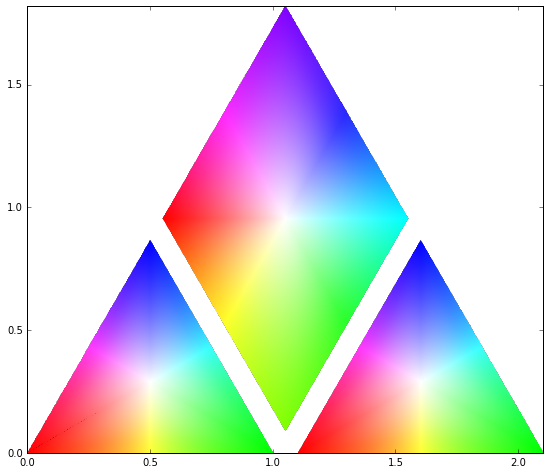

In [100]:
def interpolate_colors(offset=0.05):

    h = 0.5 * np.tan(np.pi / 3)
    offsety = offset * np.tan(np.pi / 3)
    # create empty grids to interpolate to
    x0 = 0.5
    y0 = x0 * np.tan(np.pi / 6)
    X = np.reshape(np.repeat(np.linspace(0, 2 + 2 * offset, 1000), 1000), (1000, 1000), 'F')
    Y = np.reshape(np.repeat(np.linspace(0, 2 * h + offsety, 1000), 1000), (1000, 1000), 'C')
    H = np.nan * np.zeros_like(X)
    S = np.nan * np.zeros_like(X)
    V = np.nan * np.ones_like(X)
    A = np.nan * np.ones_like(X)

    # create masks for cation, anion triangle and upper and lower diamond
    ind_cat = np.logical_or(np.logical_and(X < 0.5, Y < 2 * h * X),
                            np.logical_and(X > 0.5, Y < (2 * h * (1 - X))))
    ind_an = np.logical_or(np.logical_and(X < 1.5 + (2 * offset), Y < 2 * h * (X - 1 - 2 * offset)),
                           np.logical_and(X > 1.5 + (2 * offset), Y < (2 * h * (1 - (X - 1 - 2 * offset)))))
    ind_ld = np.logical_and(
        np.logical_or(np.logical_and(X < 1.0 + offset, Y > -2 * h * X + 2 * h * (1 + 2 * offset)),
                      np.logical_and(X > 1.0 + offset, Y > 2 * h * X - 2 * h)),
        Y < h + offsety)
    ind_ud = np.logical_and(np.logical_or(np.logical_and(X < 1.0 + offset, Y < 2 * h * X),
                                          np.logical_and(X > 1.0 + offset, Y < -2 * h * X + 4 * h * (1 + offset))),
                            Y > h + offsety)
    ind_d = np.logical_or(ind_ld == 1, ind_ud == 1)

    # Hue: convert x,y to polar coordinates
    # (angle between 0,0 to x0,y0 and x,y to x0,y0)
    H[ind_cat] = np.pi + np.arctan2(Y[ind_cat] - y0, X[ind_cat] - x0)
    H[ind_cat] = np.mod(H[ind_cat] - np.pi / 6, 2 * np.pi)
    H[ind_an] = np.pi + np.arctan2(Y[ind_an] - y0, X[ind_an] - (x0 + 1 + (2 * offset)))
    H[ind_an] = np.mod(H[ind_an] - np.pi / 6, 2 * np.pi)
    H[ind_d] = np.pi + np.arctan2(Y[ind_d] - (h + offsety), X[ind_d] - (1 + offset))

    # Saturation: 1 at edge of triangle, 0 in the centre,
    # Clough Tocher interpolation, square root to reduce central white region
    xy_cat = np.array([[0.0, 0.0],
                       [x0, h],
                       [1.0, 0.0],
                       [x0, y0]])
    xy_an = np.array([[1 + (2 * offset), 0.0],
                      [x0 + 1 + (2 * offset), h],
                      [2 + (2 * offset), 0.0],
                      [x0 + 1 + (2 * offset), y0]])
    xy_d = np.array([[x0 + offset, h + offsety],
                     [1 + offset, 2 * h + offsety],
                     [x0 + 1 + offset, h + offsety],
                     [1 + offset, offsety],
                     [1 + offset, h + offsety]])
    z_cat = np.array([1.0, 1.0, 1.0, 0.0])
    z_an = np.array([1.0, 1.0, 1.0, 0.0])
    z_d = np.array([1.0, 1.0, 1.0, 1.0, 0.0])
    s_cat = interpolate.CloughTocher2DInterpolator(xy_cat, z_cat)
    s_an = interpolate.CloughTocher2DInterpolator(xy_an, z_an)
    s_d = interpolate.CloughTocher2DInterpolator(xy_d, z_d)
    S[ind_cat] = s_cat.__call__(X[ind_cat], Y[ind_cat])
    S[ind_an] = s_an.__call__(X[ind_an], Y[ind_an])
    S[ind_d] = s_d.__call__(X[ind_d], Y[ind_d])
    # Value: 1 everywhere
    V[ind_cat] = 1.0
    V[ind_an] = 1.0
    V[ind_d] = 1.0
    # Alpha: 1 everywhere
    A[ind_cat] = 1.0
    A[ind_an] = 1.0
    A[ind_d] = 1.0
    # convert HSV to RGB
    R, G, B = hsvtorgb(H, S ** 0.5, V)
    RGBA = np.dstack((R, G, B, A))
    return s_cat, s_an, s_d, RGBA

s_cat, s_an, s_d, RGBA = interpolate_colors()

offset = 0.05
offsety = offset * np.tan(np.pi / 3)
h = 0.5 * np.tan(np.pi / 3)
# visualise
plt.imshow(RGBA,
           origin='lower',
           aspect=1.0,
           extent=(0, 2 + 2 * offset, 0, 2 * h + offsety))
plt.savefig('rgba.png')

In [98]:
print(RGBA[0])

[[        nan         nan         nan         nan]
 [ 1.          0.00338921  0.00164816  1.        ]
 [ 1.          0.00677947  0.00329209  1.        ]
 ..., 
 [ 0.00677947  1.          0.00329209  1.        ]
 [ 0.00338921  1.          0.00164816  1.        ]
 [        nan         nan         nan         nan]]


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in remainder


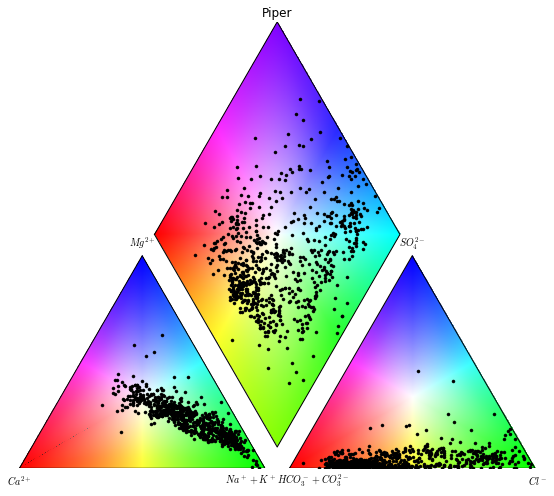

In [59]:
piper_plot('C:/Users/PAULINKENBRANDT/PycharmProjects/Peeters_Piper/GW20130314-0057-s02.csv',"Piper")

In [29]:
###
# Plot example data
###

# Load data
dat = np.loadtxt('C:/Users/PAULINKENBRANDT/PycharmProjects/Peeters_Piper/GW20130314-0057-s02.csv',
                 delimiter=',',
                 skiprows=1)
# define extent map
bbox = np.array([np.min(dat[:, 1]),
                 np.min(dat[:, 0]),
                 np.max(dat[:, 1]),
                 np.max(dat[:, 0])])
bbox = bbox + np.array([-0.05 * (bbox[2] - bbox[0]),
                        -0.05 * (bbox[3] - bbox[1]),
                        0.05 * (bbox[2] - bbox[0]),
                        0.05 * (bbox[3] - bbox[1])])

In [60]:
dat_piper = np.loadtxt('C:/Users/PAULINKENBRANDT/PycharmProjects/Peeters_Piper/GW20130314-0057-s02.csv',
                 delimiter=',',
                 skiprows=1)

In [82]:
mol_convert(dat_piper[:, 2:10])[1]

array([[ 0.17149553,  0.08616928,  0.74233519],
       [ 0.44846458,  0.04882321,  0.50271221],
       [ 0.44134113,  0.01779129,  0.54086758],
       ..., 
       [ 0.60244677,  0.05000177,  0.34755146],
       [ 0.53418463,  0.07020797,  0.39560739],
       [ 0.55919051,  0.04828735,  0.39252214]])

In [68]:
pplot = piper(data)

NaK


In [78]:
data.columns

Index(['Latitude', 'Longitude', 'Ca', 'Mg', 'Na', 'K', 'HCO3', 'CO3', 'Cl',
       'SO4', 'NaK', 'Na_meq', 'K_meq', 'NaK_meq', 'Ca_meq', 'Mg_meq',
       'Cl_meq', 'HCO3_meq', 'CO3_meq', 'SO4_meq', 'anions', 'cations', 'EC',
       'CBE', 'maj_cation', 'maj_anion', 'water_type', 'ClEC', 'HCO3EC',
       'CO3EC', 'SO4EC', 'NaEC', 'KEC', 'CaEC', 'MgEC', 'NaKEC'],
      dtype='object')

In [84]:
data['ClEC']

0      74.229281
1      50.269595
2      54.086120
3      16.533182
4      69.954191
5      21.869172
6      56.810557
7      82.985245
8      53.506038
9      59.491334
10     83.247341
11     23.920095
12     73.586348
13     23.019111
14     20.493106
15     49.473163
16     56.810557
17     51.696364
18     30.510246
19     46.017959
20     85.193566
21     65.467919
22     58.743300
23     68.349589
24     54.503038
25     27.222254
26     20.988331
27     82.648211
28     41.732847
29     45.518407
         ...    
721    39.565158
722    73.757414
723    24.785646
724    50.848154
725    35.267870
726    36.427980
727    40.858355
728    15.485514
729    25.396915
730    62.277922
731    26.354380
732    22.891508
733    75.038690
734    40.086594
735    34.311112
736    27.763393
737    66.907189
738    38.332486
739    59.052045
740    16.190765
741    57.491677
742    70.513366
743    33.399028
744    69.232492
745    73.862758
746    72.426758
747    18.151157
748    34.7539

In [ ]:
def mol_convert(dat_piper):
    # Convert chemistry into plot coordinates
    gmol = np.array([40.078, 24.305, 22.989768, 39.0983, 61.01714, 60.0092, 35.4527, 96.0636])
    eqmol = np.array([2., 2., 1., 1., 1., 2., 1., 2.])
    n = dat_piper.shape[0]
    meqL = (dat_piper / gmol) * eqmol
    sumcat = np.sum(meqL[:, 0:4], axis=1)
    suman = np.sum(meqL[:, 4:8], axis=1)
    cat = np.zeros((n, 3))
    an = np.zeros((n, 3))
    cat[:, 0] = meqL[:, 0] / sumcat  # Ca
    cat[:, 1] = meqL[:, 1] / sumcat  # Mg
    cat[:, 2] = (meqL[:, 2] + meqL[:, 3]) / sumcat  # Na+K
    an[:, 0] = (meqL[:, 4] + meqL[:, 5]) / suman  # HCO3 + CO3
    an[:, 2] = meqL[:, 6] / suman  # Cl
    an[:, 1] = meqL[:, 7] / suman  # SO4
    return cat, an


def ion_in_cartesian(cat,an, offset=0.05):
    # Convert into cartesian coordinates
    h = 0.5 * np.tan(np.pi / 3)
    cat_x = 0.5 * (2 * cat[:, 2] + cat[:, 1])
    cat_y = h * cat[:, 1]
    an_x = 1 + 2 * offset + 0.5 * (2 * an[:, 2] + an[:, 1])
    an_y = h * an[:, 1]
    d_x = an_y / (4 * h) + 0.5 * an_x - cat_y / (4 * h) + 0.5 * cat_x
    d_y = 0.5 * an_y + h * an_x + 0.5 * cat_y - h * cat_x
    return cat_x, cat_y, an_x, an_y, d_x, d_y

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in remainder


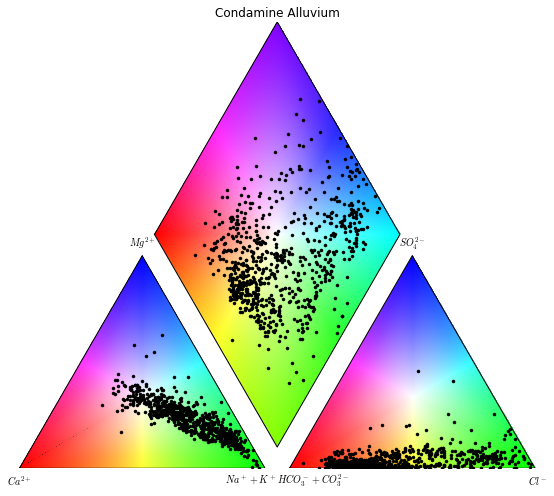

In [30]:
# Plot example data
# Piper plot
rgb = piper(dat[:, 2:10], 'Condamine Alluvium', alphalevel=1.0, color=True)


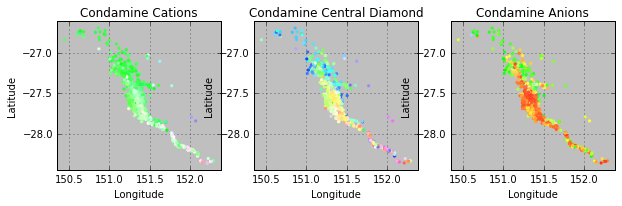

In [27]:
# Maps (only data points, no background shape files)
fig = plt.figure()
# cations
ax1 = fig.add_subplot(131,
                      aspect='equal',
                      axisbg=[0.75, 0.75, 0.75, 1])
ax1.scatter(dat[:, 1],
            dat[:, 0],
            s=10,
            c=rgb['cat'],
            edgecolor='None',
            zorder=3)
plt.title('Condamine Cations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.xlim(bbox[0], bbox[2])
plt.ylim(bbox[1], bbox[3])
# central diamond
ax2 = fig.add_subplot(132,
                      aspect='equal',
                      axisbg=[0.75, 0.75, 0.75, 1])
ax2.scatter(dat[:, 1],
            dat[:, 0],
            s=10,
            c=rgb['diamond'],
            edgecolor='None',
            zorder=3)
plt.title('Condamine Central Diamond')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(bbox[0], bbox[2])
plt.ylim(bbox[1], bbox[3])
plt.grid()
# anions
ax3 = fig.add_subplot(133,
                      aspect='equal',
                      axisbg=[0.75, 0.75, 0.75, 1])
ax3.scatter(dat[:, 1],
            dat[:, 0],
            s=10,
            c=rgb['an'],
            edgecolor='None',
            zorder=3)
plt.title('Condamine Anions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(bbox[0], bbox[2])
plt.ylim(bbox[1], bbox[3])
plt.grid()

In [64]:
data = pd.read_csv('C:/Users/PAULINKENBRANDT/PycharmProjects/Peeters_Piper/GW20130314-0057-s02.csv')
#an = pd.DataFrame(rgb['an'],columns=['HCO3+CO3','SO4','Cl'])
#cat = pd.DataFrame(rgb['an'],columns=['Ca','Mg','Na+K'])
#diamond = pd.DataFrame(rgb['an'],columns=['R','G','B'])
complete = pd.concat([data, an,cat,diamond],axis=1)

In [38]:
def clamp(x): 
    return max(0, min(int(x), 255))
def rgb2hex(r,g,b):
    """From: https://stackoverflow.com/questions/3380726/converting-a-rgb-color-tuple-to-a-six-digit-code-in-python"""
    hex = "#{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b))
    return hex

In [41]:
def rgb2hex(r,g,b):
    hex = "#{:02x}{:02x}{:02x}".format(int(r),int(g),int(b))
    return hex

In [49]:
cat_hex = [mpl.colors.rgb2hex(i) for i in rgb['cat']]


In [55]:
import os
os.path.basename('C:/Users/PAULINKENBRANDT/PycharmProjects/Peeters_Piper/GW20130314-0057-s02.csv')

'GW20130314-0057-s02.csv'

In [53]:
data['cat_hex'] = [mpl.colors.rgb2hex(i) for i in rgb['cat']]
data['an_hex'] = [mpl.colors.rgb2hex(i) for i in rgb['an']]
data['diamond_hex'] = data['cat_hex'] = [mpl.colors.rgb2hex(i) for i in rgb['diamond']]
data

,Latitude,Longitude,Ca,Mg,Na,K,HCO3,CO3,Cl,SO4,cat_hex,an_hex,diamond_hex
0,-27.444628,151.379565,97.0,133.0,684.0,5.8,453.0,6.0,1170.0,184.0,#60aaff,#58ff43,#60aaff
1,-27.185917,151.159983,39.0,34.0,65.0,2.2,204.0,0.1,133.0,17.5,#edbfff,#ecff49,#edbfff
2,-26.841355,150.444008,12.0,11.0,79.0,0.8,129.0,0.1,92.0,4.1,#a0ffbb,#ddff3b,#a0ffbb
3,-27.555360,151.369984,38.0,27.0,88.0,1.8,378.0,5.1,46.0,8.9,#fff96c,#ff4824,#fff96c
4,-27.217028,151.187483,57.0,72.0,569.0,3.4,427.0,2.2,821.0,138.0,#63e8ff,#6eff4c,#63e8ff
5,-28.226280,152.058999,83.0,59.0,44.5,1.5,500.0,6.2,85.0,7.9,#ff546e,#ff5f29,#ff546e
6,-26.770422,150.937778,15.0,7.8,660.0,5.2,810.0,5.1,630.0,3.1,#34ff50,#d2ff37,#34ff50
7,-26.696442,150.861690,125.0,190.0,1400.0,6.0,630.0,11.5,2500.0,180.0,#46bdff,#3aff26,#46bdff
8,-27.148675,151.173790,33.0,46.0,780.0,2.0,880.0,31.5,780.0,175.0,#55ff8d,#c9ff60,#55ff8d
9,-27.384379,151.295076,42.0,64.0,445.0,2.0,445.0,2.9,580.0,180.0,#76fcff,#99ff73,#76fcff


In [52]:
complete

,Latitude,Longitude,Ca,Mg,Na,K,HCO3,CO3,Cl,SO4,HCO3+CO3,SO4,Cl,Ca,Mg,Na+K,R,G,B,cat_hex
0,-27.444628,151.379565,97.0,133.0,684.0,5.8,453.0,6.0,1170.0,184.0,0.346200,1.000000,0.261687,0.346200,1.000000,0.261687,0.346200,1.000000,0.261687,#5cff80
1,-27.185917,151.159983,39.0,34.0,65.0,2.2,204.0,0.1,133.0,17.5,0.925182,1.000000,0.285408,0.925182,1.000000,0.285408,0.925182,1.000000,0.285408,#d2fffb
2,-26.841355,150.444008,12.0,11.0,79.0,0.8,129.0,0.1,92.0,4.1,0.868069,1.000000,0.233013,0.868069,1.000000,0.233013,0.868069,1.000000,0.233013,#56ff66
3,-27.555360,151.369984,38.0,27.0,88.0,1.8,378.0,5.1,46.0,8.9,1.000000,0.280611,0.141553,1.000000,0.280611,0.141553,1.000000,0.280611,0.141553,#b1ffbc
4,-27.217028,151.187483,57.0,72.0,569.0,3.4,427.0,2.2,821.0,138.0,0.429788,1.000000,0.297392,0.429788,1.000000,0.297392,0.429788,1.000000,0.297392,#43ff5a
5,-28.226280,152.058999,83.0,59.0,44.5,1.5,500.0,6.2,85.0,7.9,1.000000,0.372190,0.159263,1.000000,0.372190,0.159263,1.000000,0.372190,0.159263,#e9a1ff
6,-26.770422,150.937778,15.0,7.8,660.0,5.2,810.0,5.1,630.0,3.1,0.823159,1.000000,0.216913,0.823159,1.000000,0.216913,0.823159,1.000000,0.216913,#0bff0a
7,-26.696442,150.861690,125.0,190.0,1400.0,6.0,630.0,11.5,2500.0,180.0,0.227796,1.000000,0.150787,0.227796,1.000000,0.150787,0.227796,1.000000,0.150787,#41ff5e
8,-27.148675,151.173790,33.0,46.0,780.0,2.0,880.0,31.5,780.0,175.0,0.786377,1.000000,0.375906,0.786377,1.000000,0.375906,0.786377,1.000000,0.375906,#20ff2c
9,-27.384379,151.295076,42.0,64.0,445.0,2.0,445.0,2.9,580.0,180.0,0.601490,1.000000,0.452930,0.601490,1.000000,0.452930,0.601490,1.000000,0.452930,#44ff63
